# [Based on paper A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- This paper popularised the vector embedding conecpt solving the curse of dimensionality (due to one hot encoding)
- A lookup table was used to map words to their vector embeddings, which were then updated during training to optimize the language modeling task.
- The embedding captured semantic and syntactic relationships between words

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocab and characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
#build dataset 
# context length: how many characters do we take to predict next one
block_size = 3
X,Y = [],[]
for w in words:
    
    # print(w)
    context = [0]* block_size
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context),'--->',itos[ix])
        context = context[1:] + [ix] #crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [7]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [8]:
C = torch.randn([27,2])

In [9]:
C

tensor([[-0.3093, -0.3305],
        [ 0.6806, -0.0063],
        [-0.6788, -1.5167],
        [-0.1184,  0.1131],
        [-2.2830, -1.0615],
        [-0.3741, -0.2695],
        [-0.5587,  0.3579],
        [-0.4008, -0.0920],
        [ 1.9187, -0.3355],
        [-0.6552,  0.2827],
        [ 0.1452,  1.1455],
        [-2.4615, -1.2167],
        [ 0.0877,  0.8273],
        [ 1.3324,  0.1750],
        [ 0.9998,  0.1663],
        [ 0.0134,  0.6009],
        [ 1.4722,  0.2903],
        [ 0.0683,  0.0272],
        [-1.0487, -1.5138],
        [ 0.0333,  0.7697],
        [-0.8798, -1.6913],
        [-0.0794,  1.1707],
        [-0.6385,  0.0423],
        [ 0.7915,  0.2200],
        [ 0.1784,  0.0180],
        [ 0.6362,  1.9243],
        [ 0.2859,  0.6146]])

In [10]:
#Mapping the X character block (indices) to a 2D vector representation using the embedding lookup table.
#hence no need one hot encoding,thus good for generalization
embed = C[X]
embed.shape


torch.Size([228146, 3, 2])

In [11]:
W1 = torch.randn(6,100)
b1 = torch.randn(100)
embed.shape

torch.Size([228146, 3, 2])

In [12]:
# to embed the input layer options
torch.cat([embed[:,0,:],embed[:,1,:],embed[:,2,:]],1).shape
torch.cat(torch.unbind(embed,dim=1),1).shape
#best options is to use tensor.view as it rearrange feature for the tensor only
# -1 or embed.shape[0]
embed.view(-1,6)

tensor([[-0.3093, -0.3305, -0.3093, -0.3305, -0.3093, -0.3305],
        [-0.3093, -0.3305, -0.3093, -0.3305, -0.3741, -0.2695],
        [-0.3093, -0.3305, -0.3741, -0.2695,  1.3324,  0.1750],
        ...,
        [ 0.2859,  0.6146,  0.2859,  0.6146,  0.6362,  1.9243],
        [ 0.2859,  0.6146,  0.6362,  1.9243,  0.2859,  0.6146],
        [ 0.6362,  1.9243,  0.2859,  0.6146,  0.1784,  0.0180]])

In [13]:
#hidden layer
h = embed.view(-1,6) @ W1 + b1
h.shape

torch.Size([228146, 100])

In [14]:
#output layer
W2 = torch.randn(100,27)
b2 = torch.randn(27)


In [15]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [16]:
counts = logits.exp()
prob = counts/counts.sum(dim=1,keepdim=True)

In [17]:
prob.shape

torch.Size([228146, 27])

In [18]:
torch.arange(16)
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [19]:
# loss = - prob[torch.arange(16),Y].log().mean()
# loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [16], [228146]

# Build dataset and splitting

In [ ]:
# build the vocab and characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

print(itos)
print(vocab_size)

In [21]:
block_size = 3 #context length: how many character do we take to predict the next one ?

def build_dataset(words):
# context length: how many characters do we take to predict next one
    X,Y = [],[]
    for w in words:
        
        # print(w)
        context = [0]* block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context),'--->',itos[ix])
            context = context[1:] + [ix] #crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = build_dataset(words[:n1])
Xval,Yval = build_dataset(words[n1:n2])
Xtest,Ytest = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Steps to optimize the loss (thoughts process/took steps)
### For lr=-0.1, hidden_layer = 100,vector_embedding(C)=2
 - the loss converges at about 2.58 after training alots of time.
 - Introduced decay lr = -0.01 after training some times to decrease the loss decreased at around 2.29
 - Still model is Underfitting(might be due to model being to simple bump hidden layer to 300)
### For lr = -0.1,hidden_layer=300,vector_embedding(C)=2
 - the loss converges at about 2.41 after training 8*10000 times.
 - Introduced decay lr = -0.01 after training some times to decrease the loss decreased at around 2.24
 - Loss is not decreasing,still model is Underfitting(might be due to vector embedding in 2d creating a bottle neck)
### For lr = -0.1,hidden_layer=200,vector_embedding(C)=10
- after training 8*10000 times loss converges at about 2.22
- Introduced decay lr = -0.01 after training some times to decrease the loss decreased at around 2.06
- which is much better parameters than previous hyperparameters

In [22]:
# writing all about neural net layer here
n_embd = 10 #the dimensionality of the character embedding vectors
n_hidden = 200 #the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) #for reproducibility
#C is a lookup table for vector embedding the words
C = torch.randn(vocab_size,n_embd,generator=g)
#input layer x hidden layer
# according to kaiming paper for proper initialization of weights
W1 = torch.randn(block_size*n_embd,n_hidden,generator=g) * (5/3)/((block_size*n_embd)**0.5)
b1 = torch.randn(n_hidden,generator=g)
#hidden layer x output layer
W2 = torch.randn(n_hidden,vocab_size,generator=g)
b2 = torch.randn(vocab_size,generator=g)
parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad = True

In [23]:
sum(p.nelement() for p in parameters)
print(X.shape[0])


228146


In [24]:
# selecting learning rate
# lre = torch.linspace(-3,0,1000)
# lre = 10 **lre 


## Mini Batch size Training
- 32 batchsize of data are being processed at a time more efficient and faster for processing the dataset.
- as processing all the dataset(very large) is inefficient and memory intensive not worth it. 

In [51]:
track_loss = []
track_lre = []
track_epoch = []
max_steps = 200000
batch_size=32
for epoch in range(max_steps):
    #mini batch construct processing 32 batchsize of dataset a time more efficient
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix],Ytr[ix] #batch X,Y
    #forward pass
    embed = C[Xb] #embed the characters into vectors
    embcat = embed.view(-1,block_size*n_embd) #cocatenate the vectors
    #tanh on hidden layer on paper
    hpreact = embcat @ W1 + b1 #hidden layer pre-activation
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    # pytorch own cross entropy function
    # counts = logits.exp()
    # prob = counts / counts.sum(1,keepdims=True)
    # loss =- prob[torch.arange(16),Y].log().mean()
    loss = F.cross_entropy(logits,Yb)
    #backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    #step learning rate decay
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data+= -lr * p.grad
    
    track_loss.append(loss.log10().item())
    track_epoch.append(epoch)
    # track_lre.append(lre[epoch])


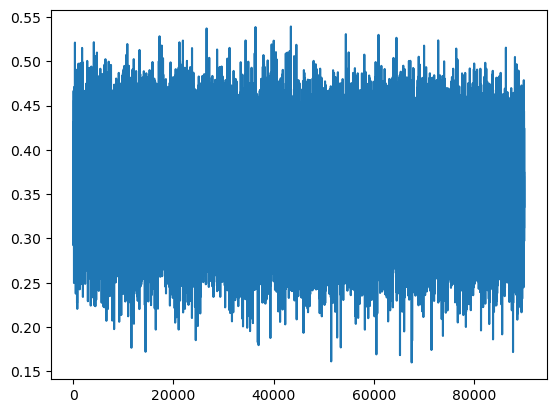

In [52]:
# plt.plot(track_lre,track_loss)
plt.plot(track_epoch,track_loss)
plt.show()


In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [53]:
embed = C[Xtr]
h = torch.tanh(embed.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ytr)
loss

tensor(2.2811, grad_fn=<NllLossBackward0>)

In [54]:
embed = C[Xval]
h = torch.tanh(embed.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Yval)
loss

tensor(2.2925, grad_fn=<NllLossBackward0>)

In [55]:
embed = C[Xtest]
h = torch.tanh(embed.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ytest)
loss

tensor(2.2950, grad_fn=<NllLossBackward0>)

In [56]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size 
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))


mora.
mayah.
seel.
ndyn.
alarethancendrlee.
adeledoeliighay.
jenleigineso.
aar.
katelmynara.
noshibergiaghies.
kande.
jeyq.
xeleana.
usmence.
ryyah.
faeha.
kaysh.
samyah.
hal.
aadyansun.


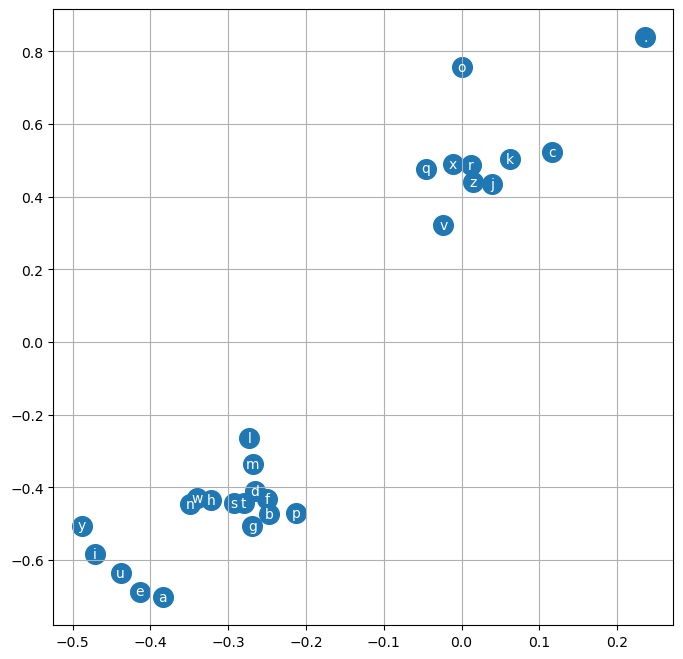

In [261]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
# this visualize only works when C is 2d
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')
plt.show()

# Interpretation of above graph
- Some commonly repeated words are cluster together in 2d vector embedding from lookup table C
- eg. a,e,i,o,u are vowel and closely related hence scatter together, '.' is special character so it is very further away from all others characters 